# Efficient [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) with [GRAPE](https://github.com/AnacletoLAB/grape)
In this tutorial, we will explore the concept of [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) and its importance in network analysis. We will start by discussing the [Brandes algorithm](http://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf), a well-known method for computing [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) in Python pseudocode. From there, we will move on to the parallel Rust implementation of the algorithm in the [GRAPE](https://github.com/AnacletoLAB/grape) library. We will use citation and protein-protein interaction graphs to demonstrate the algorithm, and briefly describe how it can be distributed over a computing cluster. By the end of this tutorial, you will have a good understanding of how to compute [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) and apply it to your own network analysis projects using [GRAPE](https://github.com/AnacletoLAB/grape).

## A brief premise on graphs
[Graphs](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics)) are a fundamental data structure used in a wide range of scientific and engineering fields. They are used to represent relationships between objects, such as social networks, transportation systems, and biological pathways. One important measure of the importance of a node in a graph is its [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality). This measure quantifies the number of shortest paths that go through a given node, indicating its importance as a connector between different parts of the graph.

Computing [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) can be a challenging problem, particularly for large-scale graphs. The naive approach of computing all shortest paths between all pairs of nodes is computationally expensive and not practical for graphs with millions or billions of nodes. Several algorithms have been developed to efficiently compute betweenness centrality, and one of the most widely used algorithms is the [Brandes algorithm](http://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf).

The [Brandes algorithm](http://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf) is an exact algorithm that computes the [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) of all nodes in a graph. It is based on a dynamic programming approach that iteratively computes the contribution of each node to the [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) of all pairs of nodes. Despite its effectiveness, the [Brandes algorithm](http://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf) can be slow for large graphs.

To address this issue, researchers have tried to develop faster algorithms for computing [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality). One such algorithm is the lock-free parallel algorithm for computing [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) [developed by Kamesh Madduri and David Bader](https://pennstate.pure.elsevier.com/en/publications/a-faster-parallel-algorithm-and-efficient-multithreaded-implement). This algorithm is optimized for high-performance computing and takes advantage of modern hardware features, such as spatial cache locality and lock-free parallelization.

We will then demonstrate how to use the [GRAPE](https://github.com/AnacletoLAB/grape) library to compute [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) on three citation graphs and three protein-protein interaction graphs.

## What is [GRAPE](https://github.com/AnacletoLAB/grape)?
🍇🍇 [GRAPE](https://github.com/AnacletoLAB/grape) 🍇🍇 is a graph processing and embedding library that enables users to easily manipulate and analyze graphs. With [GRAPE](https://github.com/AnacletoLAB/grape), users can efficiently load and preprocess graphs, generate random walks, and apply various node and edge embedding models. Additionally, [GRAPE](https://github.com/AnacletoLAB/grape) provides a fair and reproducible evaluation pipeline for comparing different graph embedding and graph-based prediction methods.

![[GRAPE](https://github.com/AnacletoLAB/grape) illustration](https://github.com/AnacletoLAB/grape/raw/main/images/sequence_diagram.png?raw=true)

## What is Betweenness Centrality?
Betweenness centrality is a measure of the importance of a node (or sometimes an edge) in a network. It quantifies the extent to which a particular node lies on the shortest paths between all pairs of other nodes in the network. In other words, nodes with high [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) act as "bridges" or "hubs" that connect different parts of the network together.

## Why is [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) Important?

Betweenness centrality is important because it can help us identify key nodes that are critical to the overall functioning of a network. For example, in a social network, nodes with high [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) may be important "brokers" who connect different groups of people together. In a transportation network, nodes with high [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) may be important junctions or intersections that connect different routes together.

## How is [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) Calculated?

There are several algorithms for calculating betweenness centrality, but one of the most common is the [Brandes algorithm](http://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf). The algorithm works by computing the shortest paths between all pairs of nodes in the network, and then counting the number of times each node lies on a shortest path. Nodes with high [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) will appear on a large number of shortest paths.

Here is the pseudocode for the [Brandes algorithm](http://snap.stanford.edu/class/cs224w-readings/brandes01centrality.pdf):

```python
def betweenness_centrality(G):
    betweenness = dict.fromkeys(G, 0.0)
    for s in G:
        stack = []
        P = dict.fromkeys(G, [])
        sigma = dict.fromkeys(G, 0.0)
        sigma[s] = 1.0
        d = dict.fromkeys(G, -1)
        d[s] = 0
        Q = [s]
        while Q:
            v = Q.pop(0)
            stack.append(v)
            for w in G[v]:
                if d[w] < 0:
                    Q.append(w)
                    d[w] = d[v] + 1
                if d[w] == d[v] + 1:
                    sigma[w] += sigma[v]
                    P[w].append(v)
        delta = dict.fromkeys(G, 0.0)
        while stack:
            w = stack.pop()
            for v in P[w]:
                delta[v] += (sigma[v] / sigma[w]) * (1.0 + delta[w])
            if w != s:
                betweenness[w] += delta[w]
    return betweenness
```

In this pseudocode, `G` represents the network, and betweenness is a dictionary that will eventually contain the [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) for each node in the network. The algorithm iterates over each node in the network (for `s` in `G`), and for each node, it computes the shortest paths between all pairs of nodes using a modified breadth-first search. It then uses these shortest paths to compute the [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) for each node.


## Madduri's algorithm
The [Madduri algorithm](https://pennstate.pure.elsevier.com/en/publications/a-faster-parallel-algorithm-and-efficient-multithreaded-implement) is a lock-free parallel algorithm designed for computing [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) in small-world networks. This algorithm achieves better spatial cache locality compared to previous approaches and is optimized for high-performance computing architectures. Let's break down its key ingredients.

### What are atomic instructions?
An [atomic instruction](https://www.ibm.com/docs/en/aix/7.2?topic=services-atomic-operations) is an operation that is executed as a single, indivisible unit of work. This means that the operation cannot be interrupted or modified by any other process or thread while it is being executed. Atomic instructions are often used in concurrent programming to implement synchronization mechanisms that ensure that shared resources are accessed and updated correctly by multiple threads. For example, in a multi-threaded environment, if two threads simultaneously try to increment the same variable, an atomic instruction can ensure that the variable is incremented exactly once, and that the final value is correct. Without atomic instructions, concurrent programs could suffer from race conditions, data races, and other synchronization-related bugs.

#### Fetch add
[Fetch add](https://www.ibm.com/docs/en/aix/7.2?topic=f-fetch-add-kernel-services) is an atomic instruction that is used to atomically increment a value by a specified amount and return the original value. The operation is typically implemented at the hardware level and provides a way to update a shared resource without the need for locks or other synchronization mechanisms. In a multi-threaded environment, if multiple threads attempt to update the same variable concurrently, fetch add can ensure that each thread gets the correct original value, increments it by the specified amount, and writes the new value back to the variable atomically, without interference from other threads. This can help prevent race conditions and other synchronization-related bugs in concurrent programs. Fetch add is commonly used in algorithms that require shared counters or accumulators, such as in parallel graph processing, where it is used to compute betweenness centrality, PageRank, and other metrics.

#### Compare and swap
[Compare-and-swap (CAS)](https://en.wikipedia.org/wiki/Compare-and-swap), is an atomic instruction that is used to perform an update to a shared variable in a multi-threaded environment. It is typically used to implement mutual exclusion, synchronization, and other concurrency control mechanisms in parallel algorithms. The operation takes three operands: a memory location, an expected value, and a new value. It compares the value in the memory location with the expected value. If they match, the operation stores the new value into the memory location. If they do not match, the operation does nothing.

Compare exchange provides a way to ensure that updates to shared variables are performed atomically, without interference from other threads. It helps prevent race conditions and other synchronization-related bugs that can arise in concurrent programs. It is commonly used in algorithms that require mutual exclusion, such as locks, semaphores, and barriers, as well as in data structures that support concurrent access, such as concurrent hash tables and concurrent linked lists.

While CAS can introduce a significant overhead when the graph topology has nodes with many predecessors, one solution is to replace CAS entirely with a second iteration on the visited vector. This approach eliminates the need for CAS operations altogether and can be a more efficient solution in certain scenarios. However, it is important to note that this method may not always be the most efficient and should be considered on a case-by-case basis.

### Non-temporal store
[Non-temporal stores (NT stores)](https://lwn.net/Articles/255364/) are a type of store operation that bypass the cache hierarchy and write data directly to the main memory, without trying to store it in any cache levels. This is useful when writing to large memory regions that are not going to be used in the near future or when the data written is going to be processed sequentially, as it can reduce cache pollution and cache misses.

The `sfence` instruction is a memory barrier instruction that ensures that all preceding writes have been committed to memory before any subsequent writes are executed. It's used in conjunction with NT stores to make sure that all data is written to main memory before continuing with the execution of the program, ensuring consistency and preventing race conditions.

We will employ non-temporal stores to let the compiler know that values such as the `i`-th successor or the status of a node does not need to be updated immediately.

### Pseudocode
In this section, we will present the pseudocode of the [Madduri algorithm](https://pennstate.pure.elsevier.com/en/publications/a-faster-parallel-algorithm-and-efficient-multithreaded-implement) for computing [betweenness centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) in parallel. The algorithm has been implemented in the [GRAPE](https://github.com/AnacletoLAB/grape) library, and we will use this pseudocode to explain the implementation details.

[Find the actual Rust implementation here](https://github.com/AnacletoLAB/ensmallen/blob/e96242d1f6a7f7bfbc5eb6908f0899b527eade98/graph/src/centrality.rs#L517)

```python
import numpy as np

def get_betweenness_centrality(graph):
    # First, we init the centralities
    centralities = np.zeros(shape=graph.get_number_of_nodes())
    # Next, a vector LARGE AS THE NUMBER OF EDGES! - THIS IS A BIG ONE!
    successors = np.zeros(shape=graph.get_number_of_directed_edges(), dtype=np.uint32)
    # The counter for the successors of each node.
    successor_counts = np.zeros(shape=graph.get_number_of_nodes(), dtype=np.uint32)
    # The number of shortest paths passing through a node.
    # Note that these values are ATOMIC!
    shortest_path_counts = [AtomicU32(0) for _ in range(graph.get_number_of_nodes())]
    # Then, we fill a vector with the visited status of the nodes
    # - UNVISITED for the nodes yet to be visited
    # - JUST_VISITED for the nodes we have just visited, and...
    # - VISITED for the nodes we have visited last iteration
    # Clear, right?
    # Since we only need 3 values, we can use an `u8` with space to spare.
    # Note that we could also use just 2 bits instead of wasting 8 of them per node.
    # This may be a good idea for large graphs, but the vector of successors dwarfs
    # these other ones that scale with the number of nodes as the successors vector
    # scales with the number of edges.
    visited_status = np.full(graph.get_number_of_nodes(), UNVISITED, dtype=np.uint8)
    # We init similarly the dependencies vector.
    dependencies = np.zeros(shape=graph.get_number_of_nodes())
    # And we init the frontiers. 
    # Frontiers are unordered vectors (read more here: https://github.com/zommiommy/parallel_frontier)
    # that allow for parallel push and balanced parallel iteration.
    frontiers = [Frontier(graph.get_number_of_nodes()) for _ in range(2)]
    
    # We start to iterate on each node.
    # This iteration can be easily distributed on a cluster, just
    # divide the nodes into chunks balanced by node degree and execute
    # the task for each node. Then, simply sum the resulting betweenness
    # centrality vectors.
    for root in range(graph.get_number_of_nodes()):
        
        # First, we reset the shortest path counts.
        shortest_path_counts[:] = 0
        
        # We set the number of shortest paths in the root equal
        # to one:
        shortest_path_counts[root] = 1
        # And we set its status as visited
        visited_status[root] = VISITED
        # We clean up the first frontier, without freeing
        # the associated memory
        frontiers[0].clear()
        # And initialize it with the root node.
        frontiers[0].push(root)
        # We initialize the current depth
        current_depth = 0
        # And start BFS-ing our way through the graph
        while True:
            # First, we increase the current depth
            current_depth += 1
            # If we are going at a deeper depth than what was
            # done until now, we create a new frontier object
            if len(frontiers) < 1 + current_depth:
                # And push it onto the frontiers vector.
                frontiers.append(Frontier())
            
            # We iterate IN PARALLEL on the last frontier we have
            # expanded, which at the first iteration only contains
            # the root node:
            for src in frontiers[current_depth - 1]:
                # We retrieve the number of paths for the current node in the frontier
                # and we do so ATOMICALLY using relaxed ordering.
                # Learn more about the type of orderings here: https://doc.rust-lang.org/std/sync/atomic/enum.Ordering.html
                source_paths = shortest_path_counts[src].load(Ordering::Relaxed)
                # We retrieve its number of successors
                number_of_successors = successor_counts[src]
                # And we compute its current offset, as the sum of the comulative
                # node degree and the current number of successors, using a data-structure
                # similar to a CSR (learn more about CSR matrices here: https://scipy-lectures.org/advanced/scipy_sparse/csr_matrix.html)
                offset = graph.comulative_degree(src) + number_of_successors
                # We iterate on the neighbours of `src`
                for dst in graph.neighbours(src):
                    # If the node was not yet visited
                    if visited_status[dst] == UNVISITED:
                        # We set it as visited using a non-temporal store,
                        # as we do not care about updating immediately the
                        # value of the node and force a cache refresh.
                        non_temporal_store(
                            visited_status[dst],
                            JUST_VISITED
                        )
                    # NOTE THAT THE FOLLOWING IS NOT AN ELSE-IF!
                    # If the status of the node is either just visited
                    # or still to be visited, i.e. the value has to be
                    # locally updated, then...
                    if visited_status[dst] == JUST_VISITED or visited_status[dst] == UNVISITED:
                        # We update the number of shortest paths passing through
                        # `dst` using a FETCH ADD operation.
                        shortest_path_counts[dst].fetch_add(source_paths, Ordering::Relaxed)
                        # We set the `dst` node as one of the successors of `src`.
                        successors[offset] = dst
                        # Increase the current offset and number of successors
                        offset += 1
                        number_of_successors += 1
                # and then, we can update the successors count of the
                # node only once.
                successor_counts[src] = number_of_successors
            # We make sure our non-temporal writes have happened by now:
            sfence()
            # Next, we populate the new frontier.
            # Do note that we choose to not do it in the 
            # previous loop as the CAS operation on some graph
            # topology can cause severe over-head, and the following
            # loop if quite clean to parallelize.
            # We clear the next frontier that we are about to populate.
            frontiers[current_depth].clear()
            # We iterate IN PARALLEL on the status of the nodes.
            for node_id, status in enumerate(visited_status):
                if status == JUST_VISITED:
                    visited_status[node_id] = VISITED
                    frontiers[current_depth].push(node_id)
            # If the new frontier is empty, we have finished
            # the BFS.
            if len(frontiers[current_depth]) == 0:
                break
        # We iterate SEQUENTIALLY on the frontier in REVERSED ORDER
        # Note that we are skipping the first frontier, the one that
        # solely contains the current root node.
        for depth in reversed(range(1, current_depth+1)):
            # We get the depth-th frontier
            frontier = frontiers[depth]
            # and we start to iterate IN PARALLEL across
            # the nodes of the frontier
            for src in frontier:
                # We reset the status of the nodes
                visited_status[src] = UNVISITED
                # We retrieve the offset of the current node
                offset = graph.comulative_degree(src)
                # We need to access the dependencies.
                # Note that all dependencies are weighted by their own shortest path counts.
                dependencies[src] = shortest_path_counts[src] * sum([
                    (1.0 + shared_dependencies.get()[dst]) / shortest_path_counts[dst]
                    for dst in successors[offset:offset+successor_counts[src]]
                ])
                # We reset the successor counts
                successor_counts[src] = 0
                # And finally, we sum the centralized
                centralities[src] += dependencies[src]
    
    return centralities
```

### Parallelizing the algorithm on a computing cluster
The algorithm can be parallelized across multiple compute nodes of a cluster in a very simple way. The parallelization can be achieved by distributing the partial computation of the BC of each graph node across multiple compute nodes, and then computing the total BC by summing the partials.

Each compute node can independently compute the BC values for a subset of the graph nodes, and then communicate the partial results to a designated master node. The master node can then aggregate the partial BC values for each node and compute the final BC values for the entire graph by summing up the partial values.

Since the computations for each node are independent of each other, and since the partial BC values can be easily combined to obtain the total BC value, this approach scales well with the number of compute nodes. Furthermore, the parallelism can be easily adjusted to accommodate different cluster sizes or computational resources, making the algorithm highly flexible and efficient.

## Experiments
In this section, we will present the results of our experiments using the parallel betweenness centrality algorithm described in Madduri's paper and implemented in GRAPE. We loaded three citation graphs, Cora, CiteSeer, and PubmedDiabetes, and three protein-protein interaction graphs, Homo Sapiens, Canis Lupus, and Mus Musculus. We will show the BC scores of each graph as histograms, which will give us an insight into the centrality of nodes in the network. By comparing the results of these experiments, we will be able to understand the performance of the algorithm on different types of graphs and the distribution of BC scores in each graph.

In [1]:
from grape.datasets.linqs import Cora, CiteSeer, PubMedDiabetes, get_words_data

cora = Cora()
citeseer = CiteSeer()
pubmed = PubMedDiabetes()

2023-04-26 17:16:45.050312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-26 17:16:45.050329: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
(cora.get_number_of_nodes(), cora.get_number_of_directed_edges(), cora.get_diameter())

(4141, 108988, 6.0)

In [3]:
%%time
cora_bc = cora.get_betweenness_centrality(edges_normalization=True)

CPU times: user 1min 20s, sys: 9.19 s, total: 1min 29s
Wall time: 5.08 s


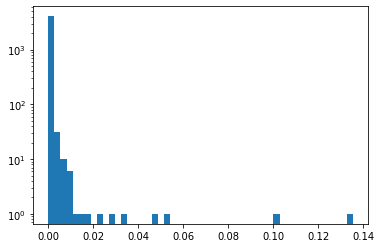

In [4]:
import matplotlib.pyplot as plt

plt.hist(cora_bc, bins=50, log=True)
plt.show()

In [5]:
(citeseer.get_number_of_nodes(), citeseer.get_number_of_directed_edges(), citeseer.get_diameter())

(7030, 219558, 6.0)

In [6]:
%%time
citeseer_bc = citeseer.get_betweenness_centrality()

CPU times: user 3min 2s, sys: 15.1 s, total: 3min 17s
Wall time: 10.9 s


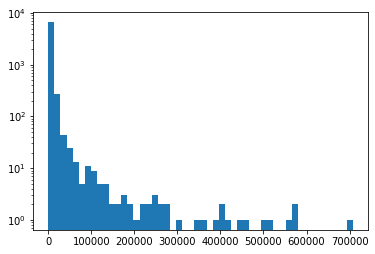

In [7]:
import matplotlib.pyplot as plt

plt.hist(citeseer_bc, bins=50, log=True)
plt.show()

In [8]:
(pubmed.get_number_of_nodes(), pubmed.get_number_of_directed_edges(), pubmed.get_diameter())

(20217, 2064713, 4.0)

In [9]:
%%time
pubmed_bc = pubmed.get_betweenness_centrality()

CPU times: user 28min 19s, sys: 1min 24s, total: 29min 43s
Wall time: 1min 39s


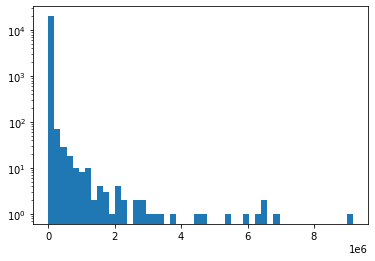

In [10]:
import matplotlib.pyplot as plt

plt.hist(pubmed_bc, bins=50, log=True)
plt.show()

In [11]:
from grape.datasets.string import HomoSapiens, CanisLupusFamiliaris, MusMusculus

homo_sapiens = HomoSapiens()
doggo = CanisLupusFamiliaris()
mouse = MusMusculus()

In [12]:
(homo_sapiens.get_number_of_nodes(), homo_sapiens.get_number_of_directed_edges(), homo_sapiens.get_diameter())

(19566, 11938498, 5.0)

In [13]:
%%time
homo_sapiens_bc = homo_sapiens.get_betweenness_centrality()

CPU times: user 28min 58s, sys: 1min 20s, total: 30min 19s
Wall time: 1min 42s


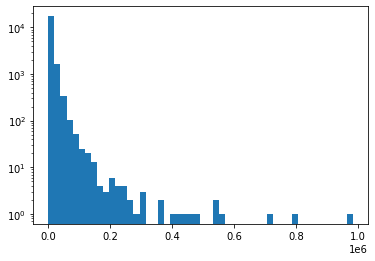

In [14]:
import matplotlib.pyplot as plt

plt.hist(homo_sapiens_bc, bins=50, log=True)
plt.show()

Let's see which of the proteins in Homo Sapiens have the highest BC:

In [15]:
import numpy as np

k = 10

highest_BC_indices = np.argpartition(homo_sapiens_bc, -k)[-k:]

[
    (
        homo_sapiens.get_node_name_from_node_id(node_id),
        homo_sapiens_bc[node_id]
    )
    for node_id in highest_BC_indices
]

[('9606.ENSP00000479618', 418310.1),
 ('9606.ENSP00000295897', 440084.25),
 ('9606.ENSP00000366488', 470096.22),
 ('9606.ENSP00000359719', 530835.1),
 ('9606.ENSP00000298910', 793801.9),
 ('9606.ENSP00000309591', 539960.0),
 ('9606.ENSP00000349960', 722263.7),
 ('9606.ENSP00000229239', 982701.5),
 ('9606.ENSP00000451828', 489310.28),
 ('9606.ENSP00000269305', 550784.4)]

In [16]:
(doggo.get_number_of_nodes(), doggo.get_number_of_directed_edges(), doggo.get_diameter())

(20199, 8591130, 5.0)

In [17]:
%%time
doggo_bc = doggo.get_betweenness_centrality()

CPU times: user 26min 17s, sys: 1min 20s, total: 27min 37s
Wall time: 1min 33s


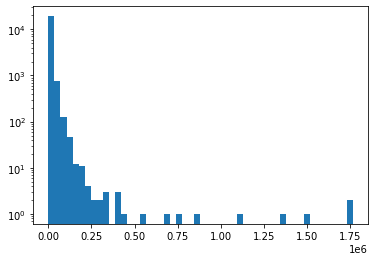

In [18]:
import matplotlib.pyplot as plt

plt.hist(doggo_bc, bins=50, log=True)
plt.show()

In [19]:
import numpy as np

k = 10

highest_BC_indices = np.argpartition(doggo_bc, -k)[-k:]

[
    (
        doggo.get_node_name_from_node_id(node_id),
        doggo_bc[node_id]
    )
    for node_id in highest_BC_indices
]

[('9615.ENSCAFP00000064590', 454357.72),
 ('9615.ENSCAFP00000013612', 560359.7),
 ('9615.ENSCAFP00000017324', 679915.0),
 ('9615.ENSCAFP00000053739', 760963.6),
 ('9615.ENSCAFP00000029000', 857573.3),
 ('9615.ENSCAFP00000053880', 1753843.1),
 ('9615.ENSCAFP00000053738', 1368979.5),
 ('9615.ENSCAFP00000056636', 1104915.4),
 ('9615.ENSCAFP00000030135', 1762596.6),
 ('9615.ENSCAFP00000028342', 1512874.1)]

In [20]:
(mouse.get_number_of_nodes(), mouse.get_number_of_directed_edges(), mouse.get_diameter())

(22048, 14496358, 7.0)

In [21]:
%%time
mouse_bc = mouse.get_betweenness_centrality()

CPU times: user 43min 16s, sys: 1min 58s, total: 45min 15s
Wall time: 2min 31s


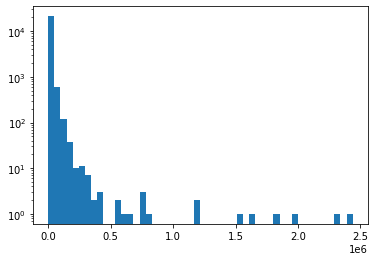

In [22]:
import matplotlib.pyplot as plt

plt.hist(mouse_bc, bins=50, log=True)
plt.show()

In [23]:
import numpy as np

k = 10

highest_BC_indices = np.argpartition(mouse_bc, -k)[-k:]

[
    (
        mouse.get_node_name_from_node_id(node_id),
        mouse_bc[node_id]
    )
    for node_id in highest_BC_indices
]

[('10090.ENSMUSP00000025791', 779730.94),
 ('10090.ENSMUSP00000098066', 808166.94),
 ('10090.ENSMUSP00000132924', 1171116.9),
 ('10090.ENSMUSP00000126567', 1206059.6),
 ('10090.ENSMUSP00000104208', 1640575.1),
 ('10090.ENSMUSP00000030940', 1978887.8),
 ('10090.ENSMUSP00000095866', 1521925.5),
 ('10090.ENSMUSP00000025402', 1847888.2),
 ('10090.ENSMUSP00000005164', 2436964.8),
 ('10090.ENSMUSP00000005606', 2299003.8)]

## Conclusions
In conclusion, we have explored the parallel betweenness centrality algorithm as described in Madduri's paper and implemented by GRAPE. We have seen how the algorithm uses `lock-free` data structures and atomic instructions to avoid race conditions and ensure parallelism. We have also discussed the performance trade-offs between different atomic instructions and how to optimize them for specific graph topologies. Finally, we have executed the algorithm on six different graphs, including citation graphs and protein-protein interaction graphs, and plotted the BC scores as histograms. Overall, the results showed that the parallel betweenness centrality algorithm is discretely efficient and relatively scalable. We hope that this tutorial has provided a useful introduction to parallel betweenness centrality and has inspired further exploration of parallel graph algorithms.

*Do you have any idea on how to further improve the algorithm performance?*